In [ ]:
# !pip install transforms3d
# !pip install open3d

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import utils

def load_pickle(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [2]:
# !unzip ./test.zip
# !tar -czvf ./test.zip testing_data_final_filtered

In [3]:
# Change these 
testing_data_dir = "./testing_data_final_filtered/testing_data/v2.2"
split_dir_test = "./testing_data_final_filtered/testing_data/"

In [4]:
def get_split_files(split_name,split_dir,data_dir):
    with open(os.path.join(split_dir, f"{split_name}.txt"), 'r') as f:
        prefix = [os.path.join(data_dir, line.strip()) for line in f if line.strip()]
        rgb = [p + "_color_kinect.png" for p in prefix]
        depth = [p + "_depth_kinect.png" for p in prefix]
        label = [p + "_label_kinect.png" for p in prefix]
        meta = [p + "_meta.pkl" for p in prefix]
    return rgb, depth, label, meta

In [5]:
rgb_files, depth_files, label_files, meta_files = get_split_files('test',split_dir_test,testing_data_dir)
with open(os.path.join(split_dir_test, f"{'test'}.txt"), 'r') as f:
    scenes = [line.strip()for line in f if line.strip()]
# print((scenes))

In [6]:
from matplotlib.cm import get_cmap
NUM_OBJECTS = 79
cmap = get_cmap('rainbow', NUM_OBJECTS)
COLOR_PALETTE = np.array([cmap(i)[:3] for i in range(NUM_OBJECTS + 3)])
COLOR_PALETTE = np.array(COLOR_PALETTE * 255, dtype=np.uint8)
COLOR_PALETTE[-3] = [119, 135, 150]
COLOR_PALETTE[-2] = [176, 194, 216]
COLOR_PALETTE[-1] = [255, 255, 225]

## Get familiar with the data

(720, 1280, 3)


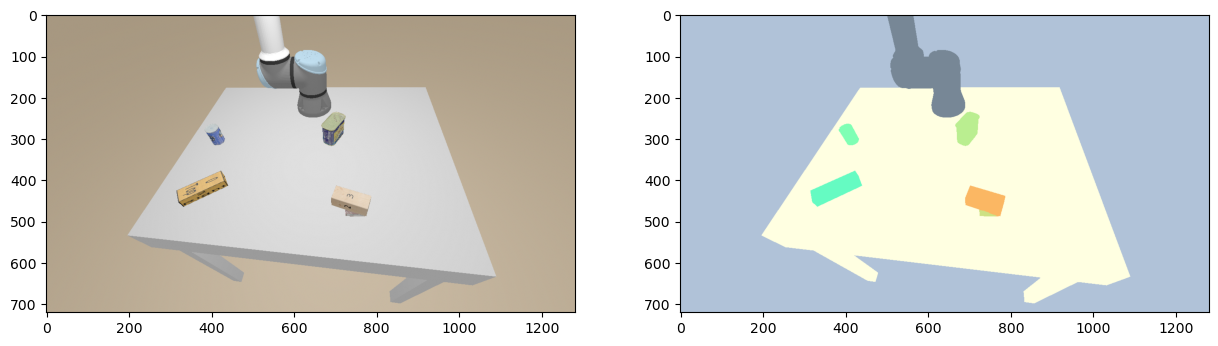

In [30]:
q = 6
rgb = np.array(Image.open(rgb_files[q])) / 255   # convert 0-255 to 0-1
depth = np.array(Image.open(depth_files[q])) / 1000   # convert from mm to m
label = np.array(Image.open(label_files[q]))
print(rgb.shape)
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(rgb)
# plt.subplot(1, 3, 2)
# plt.imshow(depth)
plt.subplot(1, 2, 2)
plt.imshow(COLOR_PALETTE[label])  # draw colorful segmentation

In [ ]:
meta = load_pickle(meta_files[0])
meta.keys()
# meta['intrinsic']
# len(meta['extents'])

In [ ]:
meta['object_names'], meta['object_ids']

In [ ]:
# poses_world = np.array([meta['poses_world'][idx] for idx in meta['object_ids']])
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])
box_sizes

## Lift depth to point cloud

In [8]:
# You can use other visualization from previous homeworks, like Open3D
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


def show_points(points):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim3d([-2, 2])
    ax.set_ylim3d([-2, 2])
    ax.set_zlim3d([0, 4])
    ax.scatter(points[:, 0], points[:, 2], points[:, 1])
    

def compare_points(points1, points2):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim3d([-0.5, 0.5])
    ax.set_ylim3d([-0.5, 0.5])
    ax.set_zlim3d([0, 1])
    ax.scatter(points1[:, 0], points1[:, 2], points1[:, 1])
    ax.scatter(points2[:, 0], points2[:, 2], points2[:, 1])

In [9]:
import copy
import open3d
from numpy.linalg import inv
from tqdm.notebook import trange, tqdm

def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    open3d.visualization.draw_geometries([source_temp, target_temp],
                                      zoom=3,
                                      front=[0.9288, -0.2951, -0.2242],
                                      lookat=[1.6784, 2.0612, 1.4451],
                                      up=[-0.3402, -0.9189, -0.1996])

src = open3d.geometry.PointCloud()
tgt = open3d.geometry.PointCloud()

# od = 4
test_dump = {}
for i in trange(len(depth_files)):
    trans = []
    poses_test = [None]*79
    meta_test = load_pickle(meta_files[i])
    train_dump = load_pickle('train_dump')
    intrinsic = meta_test['intrinsic']
    depth = np.array(Image.open(depth_files[i])) / 1000
    label = np.array(Image.open(label_files[i]))
    z = depth
    v, u = np.indices(z.shape)
    uv1 = np.stack([u + 0.5, v + 0.5, np.ones_like(z)], axis=-1)
    points_viewer = uv1 @ np.linalg.inv(intrinsic).T * z[..., None]  # [H, W, 3]
    crops_pcd = np.array([points_viewer[label==idx] for idx in meta_test['object_ids']])
    c2w_test = inv(meta_test['extrinsic'])
    for od in range(len(meta_test['object_ids'])):
        rmse = []
        t_list = []
        for k in range(len(train_dump[meta_test['object_names'][od]]['pcd'])):
            src_pcd = train_dump[meta_test['object_names'][od]]['pcd'][k]
            src_pcd = src_pcd.squeeze(0)
            if(len(src_pcd)<800):
                continue
            src_pose = train_dump[meta_test['object_names'][od]]['gt_world'][k]
            inv_gt = inv(src_pose)
            src_pcd = src_pcd@inv_gt[:3,:3].T + inv_gt[:3,3]
            src_pcd = src_pcd.reshape([-1,3])

            tgt_pcd = crops_pcd[od]
            tgt_pcd = tgt_pcd@c2w_test[:3,:3].T + c2w_test[:3,3]
            
            src_pcd = src_pcd[:1000,:]
            tgt_pcd = tgt_pcd[:1000,:]

            src.points = open3d.utility.Vector3dVector(src_pcd.reshape([-1, 3]))

            tgt.points = open3d.utility.Vector3dVector(tgt_pcd.reshape([-1, 3]))


            threshold = 0.02


            #dump_5.json with inv_gt
            trans_init = inv(inv_gt)
            q_bar = np.mean(tgt_pcd,axis=0)
            p_bar = np.mean(src_pcd,axis=0)
            trans_init[:3,3] = q_bar - np.matmul(trans_init[:3,:3],p_bar)


            reg_p2p = open3d.pipelines.registration.registration_icp(
                src, tgt, threshold, trans_init,
                open3d.pipelines.registration.TransformationEstimationPointToPoint(),
                open3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=200)
            )
            if(len(reg_p2p.correspondence_set)==0 or reg_p2p.inlier_rmse==0):
                continue
            rmse.append(reg_p2p.inlier_rmse)
            t_list.append(reg_p2p.transformation)

        # the below T is in transform from camera_src to camera_tgt
        if(len(rmse)==0):
            T = np.eye(4)
        else:
            T = t_list[np.argmin(rmse)]
#         T = reg_p2p.transformation
        trans.append(T)
        poses_test[meta_test['object_ids'][od]] = T.tolist()

    #write to json
    test_dump[scenes[i]] = {"poses_world":poses_test}
    

  0%|          | 0/400 [00:00<?, ?it/s]

/var/folders/y6/22sqq66n5yn9mmptfm9qb4hh0000gn/T/ipykernel_17284/3781156510.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  crops_pcd = np.array([points_viewer[label==idx] for idx in meta_test['object_ids']])
/Users/abhishekperi/opt/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/abhishekperi/opt/miniconda3/envs/torch/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WARNING] [KDTreeFlann::SetRawData] Failed due to no data.
[Open3D WA

In [10]:
import json

print(type(test_dump))
file = open('test_dump_seg_final_1000.json', 'w')

# dump information to that file
json.dump(test_dump, file)

# close the file
file.close()

<class 'dict'>


## Draw bounding boxes of poses on 2D image
If you are curious, take a look at `utils.py`. It is very simple.

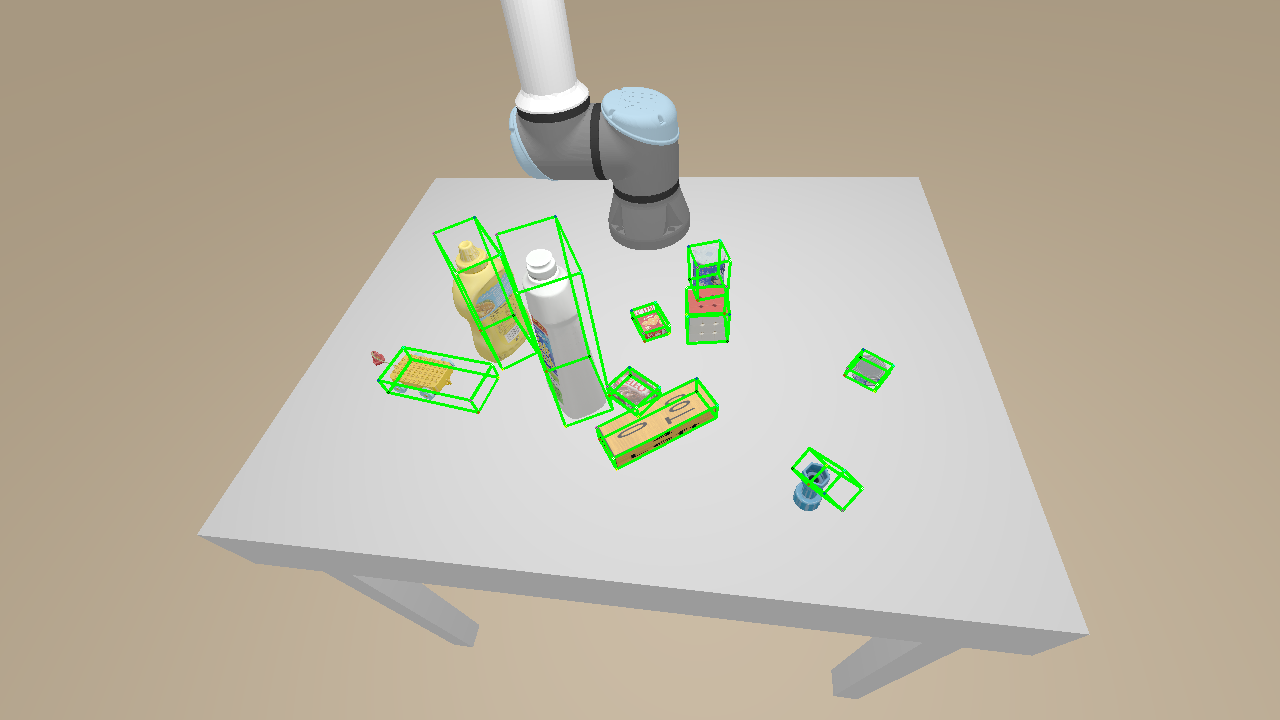

In [25]:
s =235
scene = scenes[s]
boxed_image = np.array(Image.open(rgb_files[s])) / 255 
meta = load_pickle(meta_files[s])
poses_world = np.array([test_dump[scene]['poses_world'][idx] for idx in meta['object_ids']])
box_sizes = np.array([meta['extents'][idx] * meta['scales'][idx] for idx in meta['object_ids']])
for i in range(len(poses_world)):
    utils.draw_projected_box3d(
        boxed_image, poses_world[i][:3,3], box_sizes[i], poses_world[i][:3, :3], meta['extrinsic'], meta['intrinsic'],
        thickness=2)

Image.fromarray((boxed_image * 255).astype(np.uint8))

## Test data
Test data has everything but the poses. Testing data and training data are from the same distribution.

In [ ]:
load_pickle("./testing_data_pose_filtered/testing_data/v2.2/1-1-1_meta.pkl").keys()

In [ ]:
Image.open("./testing_data/v2.2/1-1-1_color_kinect.png")